# Lab 8-1  Combining the Energy Balance and Mass Balance:  Snowmelt!
put together by Jessica Lundquist, with help from Eli Schwat and Danny Hogan

In [1]:
import os
import urllib
from urllib.error import URLError
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt

#import metpy
#from metpy.units import units
#import pint_xarray

import matplotlib.pyplot as plt

# Inputs

Below, you can see that we are pulling in a lot of data.  Turbulence data are the mean values (one variable) and variances (two variables) over 5-minute intervals at each height.  w represents winds in the vertical direction, and u and v represent winds in the horizontal.  tc is the sonic temperature, based in the speed of sound, and h2o is the water vapor concentration (or specific humidity).  Thus, we represent vertical sensible heat flux by 'w_tc__height_tower' and vertical latent heat flux by 'w_h2o_height_tower'

We are going to focus on the 3m and 10m fluxes for this lab.  Lab 7-1 downloads all of the data and does more turbulence-focused calculations.

We are also looking at the radiation data and snow pillow data, referring to Lab 5-1 and 2-2, respectively.

We also introduce the soil moisture and soil heat flux data for the first time.  

This is like the point in the symphony when suddenly all of the instruments are playing in harmony and the concert hall is filled with sound.

In [2]:
# data is downloaded to this file path
sos_download_dir='../data/sosnoqc'

# Specify start and end dates for the data. Specify the format that the dates are in.
start_date = '20230401'
end_date = '20230515'

DATE_FORMAT_STR = '%Y%m%d' # you shouldn't want to change this one

# Specify the variables you want to download. We are grabbing it ALL this time around.
VARIABLE_NAMES = [
    # Sonic Anemometer Data for 4 towers
    'tc_3m_uw',     'spd_3m_uw',     'dir_3m_uw',     'u_3m_uw',   'v_3m_uw',   'w_3m_uw',   'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    
        'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_h2o__3m_uw',  'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_h2o__3m_uw',
    'tc_10m_uw',    'spd_10m_uw',    'dir_10m_uw',    'u_10m_uw',  'v_10m_uw',  'w_10m_uw',  'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   
        'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_h2o__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_h2o__10m_uw',

   'tc_3m_ue',     'spd_3m_ue',     'dir_3m_ue',     'u_3m_ue',   'v_3m_ue',   'w_3m_ue',   'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    
        'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_h2o__3m_ue',  'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_h2o__3m_ue',
    'tc_10m_ue',    'spd_10m_ue',    'dir_10m_ue',    'u_10m_ue',  'v_10m_ue',  'w_10m_ue',  'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   
        'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_h2o__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_h2o__10m_ue',

       'tc_3m_d',      'spd_3m_d',     'dir_3m_d',     'u_3m_d',   'v_3m_d',   'w_3m_d',   'u_u__3m_d',    'v_v__3m_d',    'w_w__3m_d',    
        'u_w__3m_d',    'v_w__3m_d',  'u_tc__3m_d',  'v_tc__3m_d',   'u_h2o__3m_d',  'v_h2o__3m_d',   'w_tc__3m_d',   'w_h2o__3m_d',
    'tc_10m_d',     'spd_10m_d',    'dir_10m_d',    'u_10m_d',  'v_10m_d',  'w_10m_d',  'u_u__10m_d',   'v_v__10m_d',   'w_w__10m_d',   
        'u_w__10m_d',   'v_w__10m_d', 'u_tc__10m_d', 'v_tc__10m_d',  'u_h2o__10m_d', 'v_h2o__10m_d',  'w_tc__10m_d',  'w_h2o__10m_d',

       'tc_3m_c',  'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',   'u_u__3m_c',    'v_v__3m_c',    'w_w__3m_c',    
        'u_w__3m_c',    'v_w__3m_c',  'u_tc__3m_c',  'v_tc__3m_c',   'u_h2o__3m_c',  'v_h2o__3m_c',   'w_tc__3m_c',   'w_h2o__3m_c',
     'tc_10m_c', 'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',  'u_u__10m_c',   'v_v__10m_c',   'w_w__10m_c',   
        'u_w__10m_c',   'v_w__10m_c', 'u_tc__10m_c', 'v_tc__10m_c',  'u_h2o__10m_c', 'v_h2o__10m_c',  'w_tc__10m_c',  'w_h2o__10m_c',
    
    
    # Temperature & Relative Humidity Array 
    'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Longwave Radiometer (tower D) - for measuring incoming and outgoing longwave radiation
    'Rpile_out_9m_d',
    'Tcase_out_9m_d',
    'Rpile_in_9m_d',
    
    # Upward and downward facing shortwave radiometers (tower D) - for measuring solar radiation!
    'Rsw_in_9m_d',
    'Rsw_out_9m_d',
    
    # Soil sensors, including soil moisture (Q) and heat flux (G)
    'Qsoil_d',
    'Gsoil_d',
    'Tsoil_0_6cm_d',
    'Tsoil_1_9cm_d',
    'Tsoil_3_1cm_d',
    'Tsoil_4_4cm_d',
    'Tsoil_8_1cm_d',
    'Tsoil_9_4cm_d',
    'Tsoil_10_6cm_d',
    'Tsoil_11_9cm_d',
    'Tsoil_18_1cm_d',
    'Tsoil_19_4cm_d',
    'Tsoil_20_6cm_d',
    'Tsoil_21_9cm_d',
    'Tsoil_28_1cm_d',
    'Tsoil_29_4cm_d',
    'Tsoil_30_6cm_d',
    'Tsoil_31_9cm_d',
    
    # Snow pillow sensors
    'SWE_p1_c',
    'SWE_p2_c',
    'SWE_p3_c',
    'SWE_p4_c',
]


In [3]:
datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()

In [4]:
datelist = [date for date in datelist if date not in ['20230422','20230423']]

# Define some functions we will use

Some of these you have seen before.

In [5]:
def download_sos_data_day(date, local_download_dir, cache=True):
    """Download a netcdf file from the ftp url provided by the Earth Observing 
    Laboratory at NCAR. Data comes in one NetCDF file per day, Reynolds-Averaged 
    with a 5-minute averaging period.

    Args:
        date (str, optional): String representing a date in format '%Y%m%d'. Defaults to '20221101'.
        local_download_dir (str, optional): Directory to which files will be downloaded. Defaults 
                    to 'sosnoqc'; this directory will be created if it  does not already exist.
        cache (bool, optional): If True, looks in `local_download_dir` for requested  file, if it 
                    exists, does not redownload file. If False, downloads file from the FTP server.

    Returns:
        _type_: Relative path to the downloaded file
    """
    base_url = 'ftp.eol.ucar.edu/'
    path = 'pub/archive/isfs/projects/SOS/netcdf/noqc_geo/'
    file = f'isfs_{date}.nc'
    os.makedirs(local_download_dir, exist_ok=True)
    full_file_path = 'ftp://' + base_url + path + file
    download_file_path = os.path.join(local_download_dir, file)
    if cache and os.path.isfile(download_file_path):
        print(f"Caching...skipping download for {date}")
    else:
        urllib.request.urlretrieve(
            full_file_path,
            download_file_path   
        )
    return download_file_path

def merge_datasets_with_different_variables(ds_list, dim):
    """ Allows merging of xarray datasets with different data variables.
    Takes a list of datasets and merges two at a time them using xr.merge, but first checks that the two datasets
    have the same data vars. If they do not, datasets with missing data vars have the missing data var added to them,
    with all nan values, so that the two datasets have the same set of data vars. 
    
    WARNING: This gets slow with lots of datasets
    Args:
        ds_list (_type_): _description_
        dim (_type_): _description_
    """
    def _merge_datasets_with_different_variables(ds1, ds2, dim):
        vars1 = set(ds1.data_vars)
        vars2 = set(ds2.data_vars)
        in1_notin2 = vars1.difference(vars2)
        in2_notin1 = vars2.difference(vars1)
        # add vars with NaN values to ds1
        for v in in2_notin1:
            ds1[v] = xr.DataArray(coords=ds1.coords, dims=ds1.dims)
        # add vars with NaN values to ds2
        for v in in1_notin2:
            ds2[v] = xr.DataArray(coords=ds2.coords, dims=ds2.dims)
        return xr.concat([ds1, ds2], dim=dim)

    new_ds = ds_list.pop(0)
    while ds_list:
        new_ds = _merge_datasets_with_different_variables(
            new_ds,
            ds_list.pop(0),
            dim=dim
        )
    return new_ds

from datetime import datetime
from dateutil.relativedelta import relativedelta
def date_range(start_date, end_date, increment, period):
    """Create a list of datetimes starting on a start_date, ending on end_date,
    with incrememnts of `increment` `period` between them.
    """
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta

    return result


def apogee2temp(ds,tower):
    # hard-coded sensor-specific calibrations
    Vref = 2.5
    ID = ds[f"IDir_{tower}"]
    sns = [136, 137, 138, 139, 140]
    im = [ sns.index(x) if x in sns else None for x in ID ][0]
    # unclear if we want these, or scaled up versions
    mC0 = [57508.575,56653.007,58756.588,58605.7861, 58756.588][im] * 1e5
    mC1 = [289.12189,280.03380,287.12487,285.00285, 287.12487][im] * 1e5
    mC2 = [2.16807,2.11478,2.11822,2.08932, 2.11822][im] * 1e5
    bC0 = [-168.3687,-319.9362,-214.5312,-329.6453, -214.5312][im]* 1e5
    bC1 = [-0.22672,-1.23812,-0.59308,-1.24657, -0.59308][im]* 1e5
    bC2 = [0.08927,0.08612,0.10936,0.09234, 0.10936][im]* 1e5
    # read data
    Vtherm = ds[f"Vtherm_{tower}"]
    Vpile = ds[f"Vpile_{tower}"]*1000
    # calculation of detector temperature from Steinhart-Hart
    Rt = 24900.0/((Vref/Vtherm) - 1)
    Ac = 1.129241e-3
    Bc = 2.341077e-4
    Cc = 8.775468e-8
    TDk = 1/(Ac + Bc*np.log(Rt) + Cc*(np.log(Rt)**3))
    TDc = TDk - 273.15
    # finally, calculation of "target" temperature including thermopile measurement
    m = mC2*TDc**2 + mC1*TDc + mC0
    b = bC2*TDc**2 + bC1*TDc + bC0
    TTc = (TDk**4 + m*Vpile + b)**0.25 - 273.15
    # sufs = suffixes(TTc,leadch='') # get suffixes
    # dimnames(TTc)[[2]] = paste0("Tsfc.Ap.",sufs)
    # TTc = TTc * units('celsius')
    return TTc


# Download SoS data

Note for spring data, there was major machine room maintenance at NCAR on 22 April, which resulted in us missing data on 22 April and 23 April.  This should be backed up on a thumb drive somewhere, but personally, I have not yet tracked down those days, so be aware when downloading data.

In [8]:
# Make sure that we aren't accessing variables that don't exist in the datasets.
# This is necessary because some daily NetCDF files don't have all the expected variables
# (for example because an instrument was down). In that case, we want to add that variable
# to the dataset, filled with nans, which sosutils.merge_datasets_with_different_variables
# handles for us
datasets = []
for date in datelist:
    try:
        ds = xr.open_dataset(download_sos_data_day(date, sos_download_dir, cache=True))
    # Some dates are missing
    except URLError:
        print(f"failed on {date}, skipping")
    ds_new = ds[set(ds.data_vars).intersection(VARIABLE_NAMES)]
    datasets.append(ds_new)
# This becomes necessary if you are looking at data earlier in the season, or in the middle of the season when some measurements went offline (i.e. 1m sonics got buried)
sos_ds = merge_datasets_with_different_variables(datasets, dim='time')

Caching...skipping download for 20230401
Caching...skipping download for 20230402
Caching...skipping download for 20230403
Caching...skipping download for 20230404
Caching...skipping download for 20230405
Caching...skipping download for 20230406
Caching...skipping download for 20230407
Caching...skipping download for 20230408
Caching...skipping download for 20230409
Caching...skipping download for 20230410
Caching...skipping download for 20230411
Caching...skipping download for 20230412
Caching...skipping download for 20230413
Caching...skipping download for 20230414
Caching...skipping download for 20230415
Caching...skipping download for 20230416
Caching...skipping download for 20230417
Caching...skipping download for 20230418
Caching...skipping download for 20230419
Caching...skipping download for 20230420
Caching...skipping download for 20230421
Caching...skipping download for 20230424
Caching...skipping download for 20230425
Caching...skipping download for 20230426
Caching...skippi

# Fill in missing timestamps (with nans)

Note that this occurs if there is missing data (i.e. power went down) at the beginning or end of day - those timestamps will be left out of the dataset. 

The following code makes sure that if a timestamp is missing from the dataset, it is added with NaNs for all variables.

This results in daily datasets of different size (for example, the 20221201 dataset is missing data at the end of the day), which is annoying and can get confusing when you merge datasets together

In [9]:
dt_list = date_range(pd.to_datetime(sos_ds.time.values[0]), pd.to_datetime(sos_ds.time.values[-1]), 5, 'minutes')

In [10]:
sos_ds = sos_ds.reindex(time=dt_list)

Before plotting, we resample the SoS dataset by finding the hourly mean. We don't need the high-rate (5 minute) data to look at season long changes. Also, the snow pillow dataset has lots of nans so resampling makes the plot look better. The precipitaton dataset is already daily, so we don't need to resample it.

In [113]:
sos_dataset_60min_utc = sos_ds.resample(time="60Min").mean()
sos_dataset_60min = sos_dataset_60min_utc.shift(time=-7)

In [7]:
sos_dataset_60min = xr.open_dataset('./sos_EB_1Apr_15May2023.nc')
sos_dataset_60min = sos_dataset_60min.shift(time=-7)

sos_dataset_60min.to_netcdf("sos_SWE_T_P.nc")Now we plot the data. Note that SWE_p1_c, SWE_p2_c, SWE_p3_c, SWE_p24_ corresponse to the snow pillows beneath towers UW, UE, C, D, respectively.

We plot this in conjunction with the snow temperature, the soil temperature, and the soil moisture, to see if we can detect the onset of melt.

In [48]:
# The below code writes our 60 minute data out to netcdf.  You can use this for the lab below if 
# we're having downloading issues.  Just uncomment the line you want, if you want any of them.
# to print the dataset:

# sos_dataset_60min.to_netcdf("sos_EB_1to21April2023.nc")

# to load the dataset:

# sos_dataset_60min=xr.open_dataset("sos_EB_1to21April2023.nc")

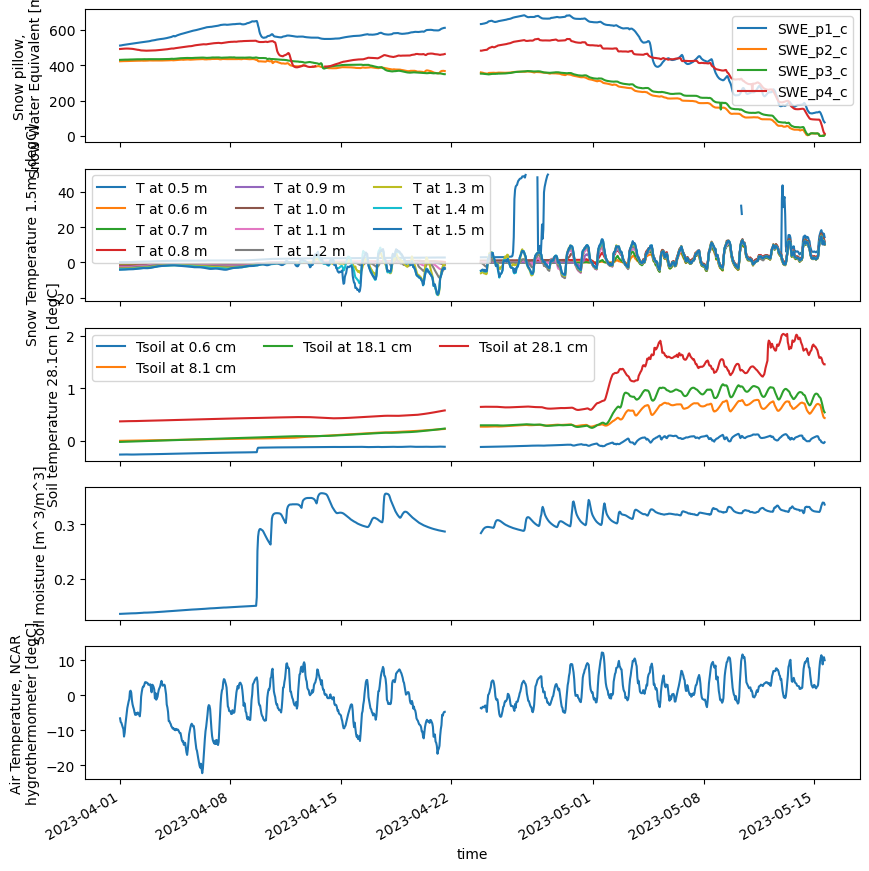

In [8]:
fig, axes = plt.subplots(5, 1, figsize=(10,10), sharex=True)
sos_dataset_60min['SWE_p1_c'].plot(ax=axes[0], label='SWE_p1_c')
sos_dataset_60min['SWE_p2_c'].plot(ax=axes[0], label='SWE_p2_c')
sos_dataset_60min['SWE_p3_c'].plot(ax=axes[0], label='SWE_p3_c')
sos_dataset_60min['SWE_p4_c'].plot(ax=axes[0], label='SWE_p4_c')

#sos_dataset_60min['Tsnow_0_4m_d'].plot(ax=axes[1], label='T at 0.4 m')
sos_dataset_60min['Tsnow_0_5m_d'].plot(ax=axes[1], label='T at 0.5 m')
sos_dataset_60min['Tsnow_0_6m_d'].plot(ax=axes[1], label='T at 0.6 m')
sos_dataset_60min['Tsnow_0_7m_d'].plot(ax=axes[1], label='T at 0.7 m')
sos_dataset_60min['Tsnow_0_8m_d'].plot(ax=axes[1], label='T at 0.8 m')
sos_dataset_60min['Tsnow_0_9m_d'].plot(ax=axes[1], label='T at 0.9 m')
sos_dataset_60min['Tsnow_1_0m_d'].plot(ax=axes[1], label='T at 1.0 m')
sos_dataset_60min['Tsnow_1_1m_d'].plot(ax=axes[1], label='T at 1.1 m')
sos_dataset_60min['Tsnow_1_2m_d'].plot(ax=axes[1], label='T at 1.2 m')
sos_dataset_60min['Tsnow_1_3m_d'].plot(ax=axes[1], label='T at 1.3 m')
sos_dataset_60min['Tsnow_1_4m_d'].plot(ax=axes[1], label='T at 1.4 m')
sos_dataset_60min['Tsnow_1_5m_d'].plot(ax=axes[1], label='T at 1.5 m')

sos_dataset_60min['Tsoil_0_6cm_d'].plot(ax=axes[2], label='Tsoil at 0.6 cm')
#sos_dataset_60min['Tsoil_1_9cm_d'].plot(ax=axes[2], label='Tsoil at 1.9 cm')
#sos_dataset_60min['Tsoil_3_1cm_d'].plot(ax=axes[2], label='Tsoil at 3.1 cm')
#sos_dataset_60min['Tsoil_4_4cm_d'].plot(ax=axes[2], label='Tsoil at 4.4 cm')
sos_dataset_60min['Tsoil_8_1cm_d'].plot(ax=axes[2], label='Tsoil at 8.1 cm')
#sos_dataset_60min['Tsoil_9_4cm_d'].plot(ax=axes[2], label='Tsoil at 9.4 cm')
#sos_dataset_60min['Tsoil_10_6cm_d'].plot(ax=axes[2], label='Tsoil at 10.6 cm')
#sos_dataset_60min['Tsoil_11_9cm_d'].plot(ax=axes[2], label='Tsoil at 11.9 cm')
sos_dataset_60min['Tsoil_18_1cm_d'].plot(ax=axes[2], label='Tsoil at 18.1 cm')
#sos_dataset_60min['Tsoil_19_4cm_d'].plot(ax=axes[2], label='Tsoil at 19.4 cm')
#sos_dataset_60min['Tsoil_20_6cm_d'].plot(ax=axes[2], label='Tsoil at 20.6 cm')
#sos_dataset_60min['Tsoil_21_9cm_d'].plot(ax=axes[2], label='Tsoil at 21.9 cm')
sos_dataset_60min['Tsoil_28_1cm_d'].plot(ax=axes[2], label='Tsoil at 28.1 cm')
#sos_dataset_60min['Tsoil_29_4cm_d'].plot(ax=axes[2], label='Tsoil at 29.4 cm')
#sos_dataset_60min['Tsoil_30_6cm_d'].plot(ax=axes[2], label='Tsoil at 30.6 cm')
#sos_dataset_60min['Tsoil_31_9cm_d'].plot(ax=axes[2], label='Tsoil at 31.9 cm')

sos_dataset_60min['Qsoil_d'].plot(ax=axes[3], label='soil moisture')

sos_dataset_60min['T_2m_c'].plot(ax=axes[4])

axes[0].legend()
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")
axes[3].set_xlabel("")
axes[1].legend(ncols=3)
axes[2].legend(ncols=3)
axes[0].set_ylabel("Snow pillow,\nSnow Water Equivalent [mm]")
# axes[0].set_xlim(dt.datetime(2023,4,1), dt.datetime(2023,4,22))
plt.show()

### Melt exited our snowpack on 10 April!
These are very exciting results (okay, at least Jessica is excited).  From the graph above, we can see that in early April, air temperatures stated going above  $0^\circ$ C during the day.  At this point in time, internal snowpack temperatures were mostly below $0^\circ$ C, but they started warming.  A cold snowfall event around 5 April resulted in the snowpack cooling again, but then everything warmed again on 8 April.  By 10 April we see some crazy movement of water in the snow (at pillows 1 and 4), we see all snowpack thermistors warming to $0^\circ$ C, and we see soil moisture jump up, more than doubling, at the same time the shallow soil temperatures rise. 

# Let's calculate some new variables and assess the total energy balance that led to these shifts.

We will do this on our 60 minute dataset, because we have a lot of variables.

## Calculate longwave radiation and surface temperatures

For calculating the temperature from the downward-facing, longwave radiometer, see EOL's methodology (https://www.eol.ucar.edu/content/calculation-long-wave-radiation)
$$
R_{lw} = R_{pile} + SB * T_{case}^4
$$
And the Steven-Boltzman law
$$
T_{surface} = \Big( \frac {R_{lw}}{ \epsilon \sigma } \Big)^\frac{1}{4}
$$

In [9]:
#SIGMA = 5.67e-8 # Stephan-Boltzmann Constant
#sos_ds = sos_ds.assign(LWout = (sos_ds.Rpile_out_9m_d + (sos_ds.Tcase_out_9m_d+273.15)**4*SIGMA),
#              LWin = (sos_ds.Rpile_in_9m_d + (sos_ds.Tcase_out_9m_d+273.15)**4*SIGMA))
# below is Eli's code and above is Danny's code -- At this point, I think we only need the below but saving the above just in case.

SB = 5.67e-08 # steven boltzman constant, W/m^2/degK^4
SNOW_EMMISIVITY = 0.98

sos_dataset_60min['LWin'] = (sos_dataset_60min['Rpile_in_9m_d'] + SB * (sos_dataset_60min['Tcase_out_9m_d']+273.15)**4)
sos_dataset_60min['LWout'] = (sos_dataset_60min['Rpile_out_9m_d'] + SB * (sos_dataset_60min['Tcase_out_9m_d']+273.15)**4)

sos_dataset_60min['Tsurf_rad_d'] = ((sos_dataset_60min['Rpile_out_9m_d'] + SB * (sos_dataset_60min['Tcase_out_9m_d']+273.15)**4)/(SNOW_EMMISIVITY*SB))**(1/4) - 273.15

# Surface Temperature
# calculate from apogees
sos_dataset_60min['Tsurf_c'] = (['time'], apogee2temp(sos_dataset_60min, 'c').values)
sos_dataset_60min['Tsurf_d'] = (['time'], apogee2temp(sos_dataset_60min, 'd').values)
sos_dataset_60min['Tsurf_ue'] = (['time'], apogee2temp(sos_dataset_60min, 'ue').values)
sos_dataset_60min['Tsurf_uw'] = (['time'], apogee2temp(sos_dataset_60min, 'uw').values)

In [10]:
# And calculate the density of air
Ra = 286.9
# above is specific gas constant for dry air in J/kg/K
sos_dataset_60min['ro'] = 100*sos_dataset_60min['P_10m_c']/(Ra * (sos_dataset_60min['T_10m_c']+273.15))

## Calculate the total energy balance each hour

The total energy balance at the snow suface is

$$
c_p^{SS} \frac{\delta T_{SS}}{\delta t} + \lambda \frac{\delta T_{S}}{\delta z} + E_{melt} = LW_{in} - LW_{out} + SW_{in} - SW_{out} - LH - SH + G 
$$

where the left hand side represents changes to the snowpack, through warming the surface temperature $c_p^{SS} \frac{\delta T_{SS}}{\delta t}$, conducting heat into lower layers of the snowpack $\lambda \frac{\delta T_{S}}{\delta z}$, or melting the snow $E_{melt}$.  

This is balanced by the heat exchange at the surface $LW_{in} - LW_{out} + SW_{in} - SW_{out} - LH - SH$ and the ground heat flux $G$.  

We need to be very careful with the signs and units of all of these terms, as we will see below.

## Calculate components and sums of surface fluxes

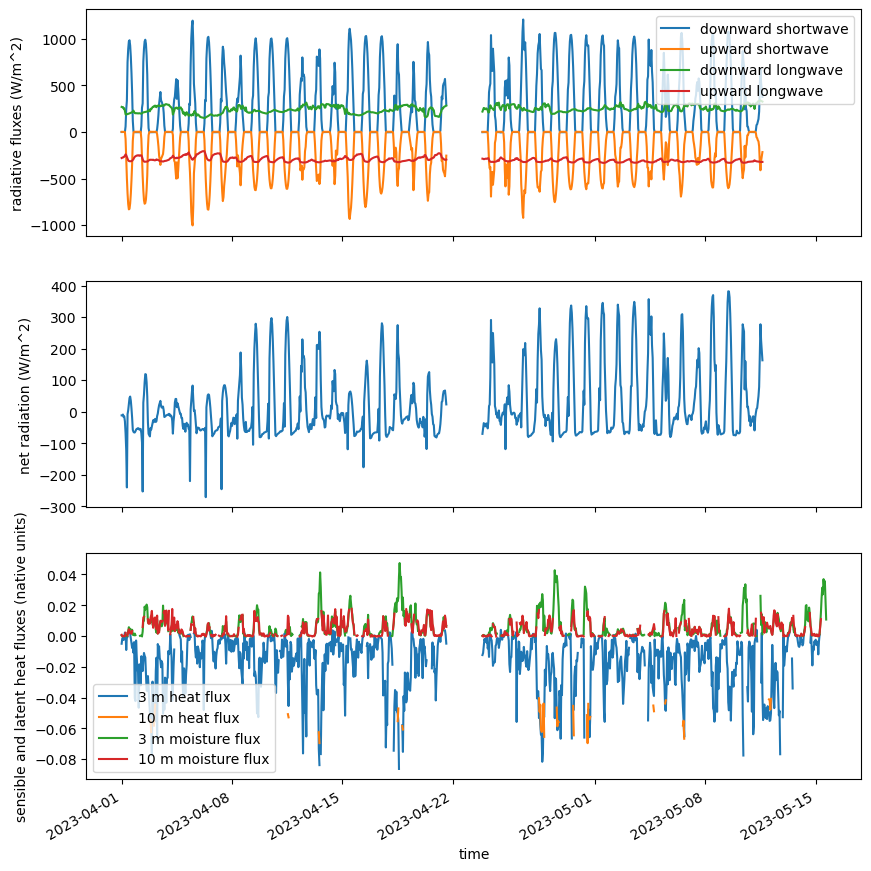

In [12]:
# import matplotlib.pyplot as plt
sos_dataset_60min['w_h2o__3m_c'] = sos_dataset_60min['w_h2o__3m_c'].where(sos_dataset_60min['w_h2o__3m_c']>np.nanpercentile(sos_dataset_60min['w_h2o__3m_c'].values,2))
sos_dataset_60min['w_h2o__10m_c'] = sos_dataset_60min['w_h2o__10m_c'].where((sos_dataset_60min['w_h2o__10m_c']>np.nanpercentile(sos_dataset_60min['w_h2o__10m_c'].values,2))
                                                                            & (sos_dataset_60min['w_h2o__10m_c']<np.nanpercentile(sos_dataset_60min['w_h2o__10m_c'].values,98)))

# sos_dataset_60min['w_tc__3m_c'] = sos_dataset_60min['w_tc__3m_c'].where(sos_dataset_60min['w_tc__3m_c']<np.nanpercentile(sos_dataset_60min['w_tc__3m_c'].values,98))
# sos_dataset_60min['w_tc__10m_c'] = sos_dataset_60min['w_tc__10m_c'].where(sos_dataset_60min['w_tc__10m_c']<np.nanpercentile(sos_dataset_60min['w_tc__10m_c'].values,98))

fig, axes = plt.subplots(3,1, figsize=(10,10), sharex=True)

sos_dataset_60min['Rsw_in_9m_d'].plot(ax=axes[0], label='downward shortwave')
(-1 * sos_dataset_60min['Rsw_out_9m_d']).plot(ax=axes[0], label='upward shortwave')
sos_dataset_60min['LWin'].plot(ax=axes[0], label='downward longwave')
(-1 * sos_dataset_60min['LWout']).plot(ax=axes[0], label='upward longwave')

(sos_dataset_60min['Rsw_in_9m_d'] + sos_dataset_60min['LWin'] - sos_dataset_60min['Rsw_out_9m_d'] - sos_dataset_60min['LWout']).plot(ax=axes[1], label='net rad')

# then, let's look at the sensible heat flux at two heights
sos_dataset_60min['w_tc__3m_c'].plot(ax=axes[2], label='3 m heat flux')
sos_dataset_60min['w_tc__10m_c'].plot(ax=axes[2], label='10 m heat flux')

# and let's look at the latent heat flux at two heights
sos_dataset_60min['w_h2o__3m_c'].plot(ax=axes[2], label='3 m moisture flux')
sos_dataset_60min['w_h2o__10m_c'].plot(ax=axes[2], label='10 m moisture flux')


axes[0].legend()
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[0].set_ylabel("radiative fluxes (W/m^2)")
axes[1].set_ylabel("net radiation (W/m^2)")
axes[2].legend()
axes[2].set_ylabel("sensible and latent heat fluxes (native units)")
#axes[3].set_ylabel("Richardson Number")
#axes[3].set_ylim(-0.5, 0.5)

plt.show()

### What do you notice in the plot above?  

The refelcted radiation looks less starting about 8 April.  This makes a big difference in the net radiation, particularly during the day     

It's also important to consider whether we have continuous snow cover and/or dust on snow during the period we chose.  You can see pictures [here](https://archive.eol.ucar.edu/docs/isf/projects/SOS/isfs/qcdata/images/20230408/index.html) -- photos show snowfall on 4 April but with dust appearing by 6 April and quite apparent (dark) on 8 April.  Note that you can click on "previous day" or "next day" on the website to see more photos.  Teaser, the night of 29 March had a laser light show all night from the lidar scanners... 

We see that the hourly average net radiation has some spikes around sunrise that would indicate that something odd is happening early in the morning.  This warrants further investigation.

We also see that, in general the 3 m and 10 m fluxes match, but sometimes the sensible heat flux at 3 m and 10 m is in different directions.  That also warrants further investigation.  Also, the direction of heat flux and moisture flux is typically opposite.  

To combine the net effect of moisture and heat flux on the energy balance of the snow, we need to pay particular attention to the direction and units of these measurements and then combine them.

### Net Turbulent Flux

First, the measurements define up as positive, so a movement of heat and moisture away from the snow is positive.  As we observed in Lab 7, Sensible heat flux is measured in K m/s and Latent heat flux is measured in g/m$^3$ m/s.  For these to comparable to the Radiative heat flux, we need to convert to W/m$^2$ at the snow surface.

The sensible heat flux is in air, and so the heat is carried by the air, so we multiply by the specific heat of air and the density of air to convert to W/m$^2$.

The latent heat flux is in mass flux and so needs to be converted to energy flux by multiplying by the latent heat of sublimation, 2835 J g$^{-1}$.  And if you are concerned that the snow first melted and then evaporated, don't worry, the latent heat of melt plus the latent heat of evaporation equals the latent heat of sublimation, so the net energy effect is the same.

**Now consider direction.**  A positive sensible heat flux moves heat away from the snow and so cools the snow.  A positie latent heat flux moves moisture away from the snow, which took energy to vaporize, and so cools the snow.  Therefore, we take the negative of the recorded values to compare directly with our radiative fluxes for a sum of fluxes towards the snow surface.

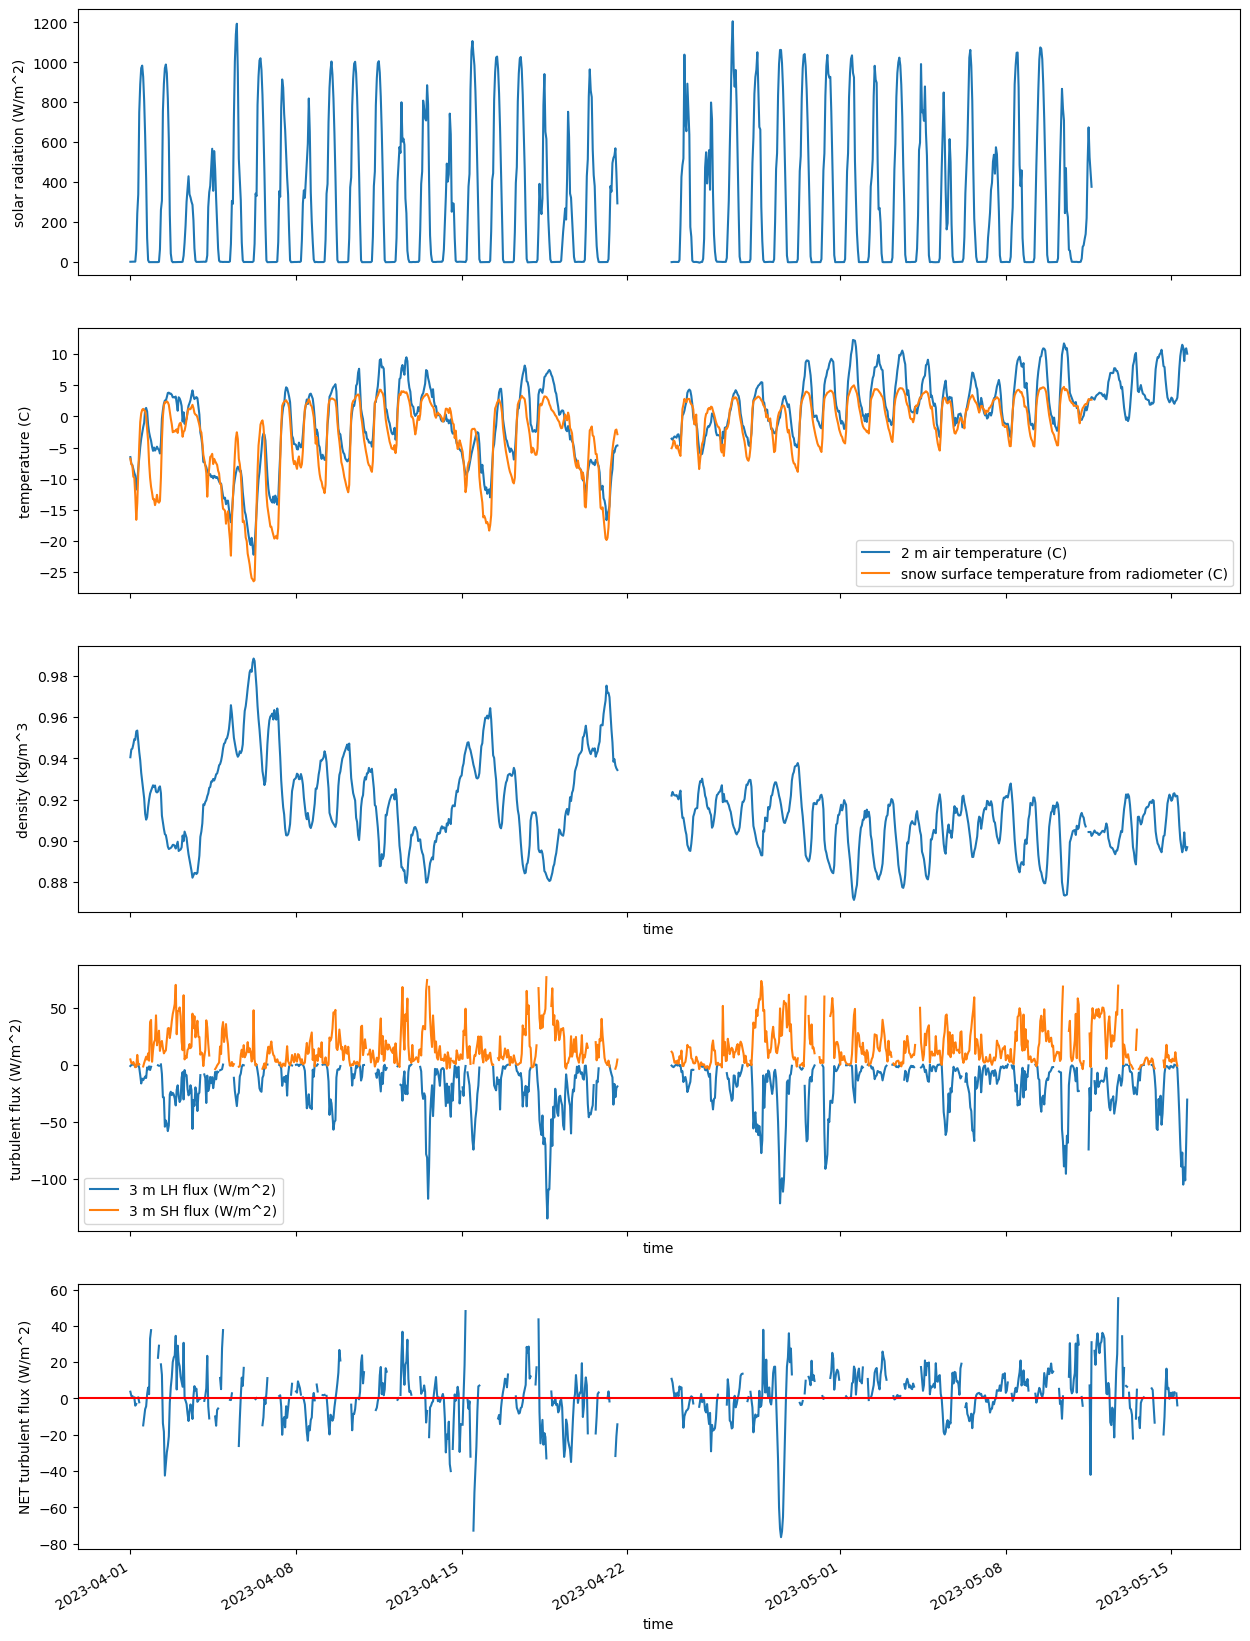

In [13]:
Lh_sub = 2835
# above we define latent heat of sublimation in J/g

cpair = 1005.7
# above is specific heat at constant pressure for dry air in J/kg/K as reported by the Glossary of Meteorology
# density of air was calculated above

# Let's make some simpler plots for the same time period to help us with interpretation.
fig, axes = plt.subplots(5,1, figsize=(15,20), sharex=True)

# I like to plot shortwave radiation to understand the timing of sunrise and relative cloudiness
sos_dataset_60min['Rsw_in_9m_d'].plot(ax=axes[0], label='downward shortwave')

# then, I like to see the actual temperatures, before the gradient is calculated
sos_dataset_60min['T_2m_c'].plot(ax=axes[1], label='2 m air temperature (C)')
sos_dataset_60min['Tsurf_rad_d'].plot(ax=axes[1], label='snow surface temperature from radiometer (C)')

# and check that denisty i okay
sos_dataset_60min['ro'].plot(ax=axes[2], label='2 m air temperature (C)')

# and the turbulent fluxes, converted to W/m^2 affecting the snowpack
(-Lh_sub * sos_dataset_60min['w_h2o__3m_c']).plot(ax=axes[3], label='3 m LH flux (W/m^2)')
(-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c']).plot(ax=axes[3], label='3 m SH flux (W/m^2)')

# and the turbulent fluxes, converted to W/m^2 affecting the snowpack
(-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c']).plot(ax=axes[4], label='sum turbulent flux (W/m^2)')

plt.axhline(y = 0, color = 'r', linestyle = '-')


axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[1].legend()
axes[3].legend()
axes[0].set_ylabel("solar radiation (W/m^2)")
axes[1].set_ylabel("temperature (C)")
axes[2].set_ylabel("density (kg/m^3")
axes[3].set_ylabel("turbulent flux (W/m^2)")
axes[4].set_ylabel("NET turbulent flux (W/m^2)")
#axes[3].set_ylim(-0.2, 0.2)

plt.show()

The plot above shows the energy balance and turbulent fluxes over the period from April 1 to May 15. After a brief cold spell in mid-April, we see a return to above 0 temperatures during the day. Net turbulent fluxes over the final period in May was primarily positive, meaning heat was generally going into the snowpack (powering melt processes).

Text(0, 0.5, 'Cumulative sum Combined flux (W/m^2*hr)')

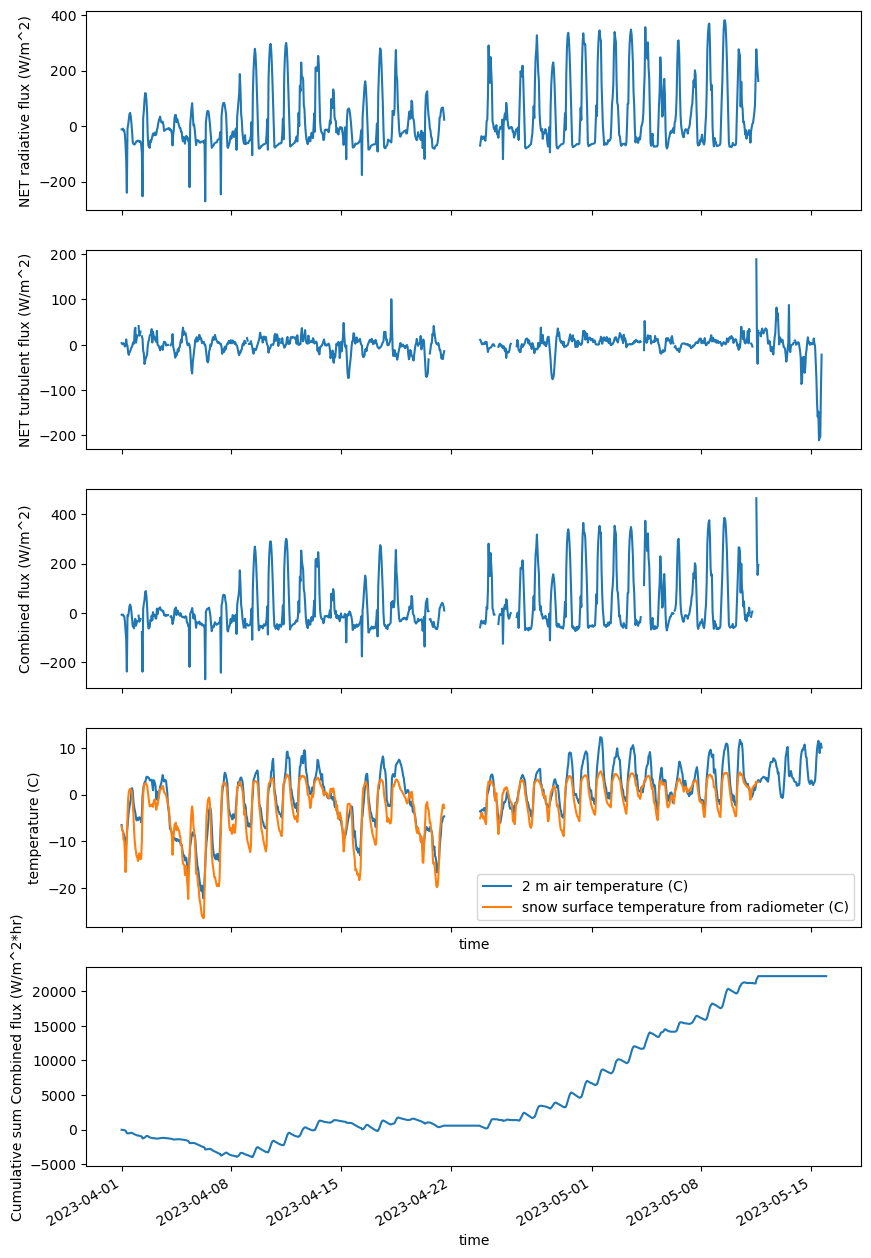

In [129]:
fig, axes = plt.subplots(5,1, figsize=(10,15), sharex=True)
(sos_dataset_60min['Rsw_in_9m_d'] + sos_dataset_60min['LWin'] - sos_dataset_60min['Rsw_out_9m_d'] - sos_dataset_60min['LWout']).plot(ax=axes[0], label='net rad')
# and the turbulent fluxes, converted to W/m^2 affecting the snowpack
(-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c']).plot(ax=axes[1], label='sum turbulent flux (W/m^2)')

#and add them all together
(sos_dataset_60min['Rsw_in_9m_d'] + sos_dataset_60min['LWin'] - sos_dataset_60min['Rsw_out_9m_d'] - sos_dataset_60min['LWout']-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c']).plot(ax=axes[2], label='net energy')

#plt.axhline(y = 0, color = 'r', linestyle = '-')

# and compare with surface temperature
# then, I like to see the actual temperatures, before the gradient is calculated
sos_dataset_60min['T_2m_c'].plot(ax=axes[3], label='2 m air temperature (C)')
sos_dataset_60min['Tsurf_rad_d'].plot(ax=axes[3], label='snow surface temperature from radiometer (C)')

#and look at the cumulative energy sum
(np.cumsum(sos_dataset_60min['Rsw_in_9m_d'] + sos_dataset_60min['LWin'] - sos_dataset_60min['Rsw_out_9m_d'] - sos_dataset_60min['LWout']-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c'])).plot(ax=axes[4], label='net energy')



axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")
#axes[1].legend()
axes[3].legend()
axes[0].set_ylabel("NET radiative flux (W/m^2)")
axes[1].set_ylabel("NET turbulent flux (W/m^2)")
axes[2].set_ylabel("Combined flux (W/m^2)")
axes[3].set_ylabel("temperature (C)")
axes[4].set_ylabel("Cumulative sum Combined flux (W/m^2*hr)")

### Very cool to see 

### And now, we combine that energy sum (fix the units, with our snow temps and SWE changes -- do we predict melt?)

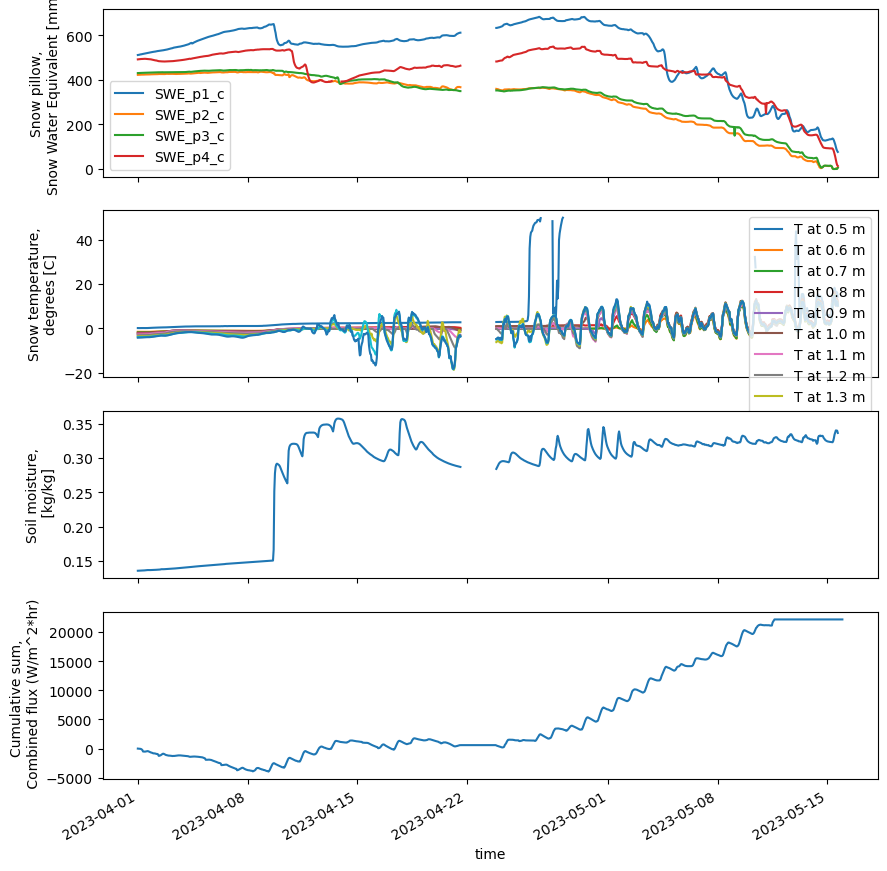

In [123]:
fig, axes = plt.subplots(4, 1, figsize=(10,10), sharex=True)
sos_dataset_60min['SWE_p1_c'].plot(ax=axes[0], label='SWE_p1_c')
sos_dataset_60min['SWE_p2_c'].plot(ax=axes[0], label='SWE_p2_c')
sos_dataset_60min['SWE_p3_c'].plot(ax=axes[0], label='SWE_p3_c')
sos_dataset_60min['SWE_p4_c'].plot(ax=axes[0], label='SWE_p4_c')

#sos_dataset_60min['Tsnow_0_4m_d'].plot(ax=axes[1], label='T at 0.4 m')
sos_dataset_60min['Tsnow_0_5m_d'].plot(ax=axes[1], label='T at 0.5 m')
sos_dataset_60min['Tsnow_0_6m_d'].plot(ax=axes[1], label='T at 0.6 m')
sos_dataset_60min['Tsnow_0_7m_d'].plot(ax=axes[1], label='T at 0.7 m')
sos_dataset_60min['Tsnow_0_8m_d'].plot(ax=axes[1], label='T at 0.8 m')
sos_dataset_60min['Tsnow_0_9m_d'].plot(ax=axes[1], label='T at 0.9 m')
sos_dataset_60min['Tsnow_1_0m_d'].plot(ax=axes[1], label='T at 1.0 m')
sos_dataset_60min['Tsnow_1_1m_d'].plot(ax=axes[1], label='T at 1.1 m')
sos_dataset_60min['Tsnow_1_2m_d'].plot(ax=axes[1], label='T at 1.2 m')
sos_dataset_60min['Tsnow_1_3m_d'].plot(ax=axes[1], label='T at 1.3 m')
sos_dataset_60min['Tsnow_1_4m_d'].plot(ax=axes[1], label='T at 1.4 m')
sos_dataset_60min['Tsnow_1_5m_d'].plot(ax=axes[1], label='T at 1.5 m')

# soil moisture
sos_dataset_60min['Qsoil_d'].plot(ax=axes[2], label='soil moisture')

#and look at the cumulative energy sum
(np.cumsum(sos_dataset_60min['Rsw_in_9m_d'] + sos_dataset_60min['LWin'] - sos_dataset_60min['Rsw_out_9m_d'] - sos_dataset_60min['LWout']-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c'])).plot(ax=axes[3], label='net energy')

axes[0].legend()
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[1].legend()
#axes[2].legend()
axes[0].set_ylabel("Snow pillow,\nSnow Water Equivalent [mm]")
axes[1].set_ylabel("Snow temperature,\ndegrees [C]")
axes[2].set_ylabel("Soil moisture,\n [kg/kg]")
axes[3].set_ylabel("Cumulative sum, \n Combined flux (W/m^2*hr)")
# axes[0].set_xlim(dt.datetime(2023,4,1), dt.datetime(2023,4,22))
plt.show()

### Total daily energy balance
Here we see the daily snow surface energy balance $R_{net} - H_s - H_l$  (there are two periods with 0s in the beginning and on April 22 and April 23). We see lots of energy over each day accrued after the cold period in early April. We see daily net energy really start to increase towards May.

Text(0.5, 1.0, 'Total Daily Energy Balance')

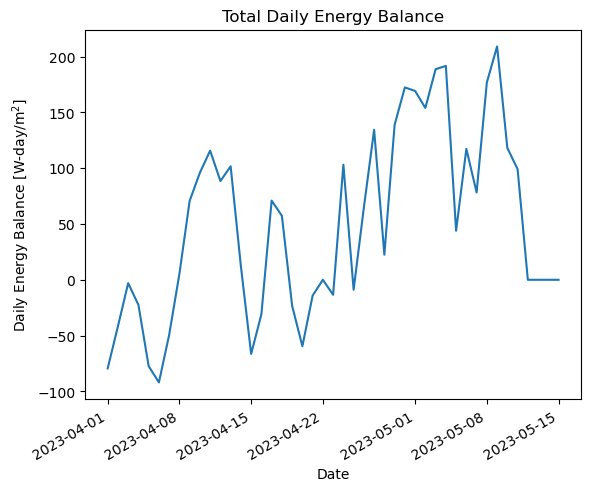

In [132]:
net_hourly = (sos_dataset_60min['Rsw_in_9m_d'] + sos_dataset_60min['LWin'] - sos_dataset_60min['Rsw_out_9m_d'] - sos_dataset_60min['LWout'] - cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c'])

net_hourly.resample(time='1D').sum().plot()
plt.ylabel('Daily Energy Balance [W-day/m$^2$]')
plt.xlabel('Date')
plt.title('Total Daily Energy Balance')

### Total Daily Temperature Change
I calculated this as the temperature change between the last and first temperature measurements over the day at each depth. I chose a representative depth of the 0.6 meter location as this was approximately in the center of the downwind snowpack from peak SWE. I would expect that before a location melts, the difference values would be essentially 0, meaning that all energy going into the snowpack is gone to melt the snow. Once snow melts we see a large increase in these differences.

In [125]:
tsnow_daily_diff_0_5m_d = sos_dataset_60min['Tsnow_0_5m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_0_5m_d'].resample(time='1D').first()
tsnow_daily_diff_0_6m_d = sos_dataset_60min['Tsnow_0_6m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_0_6m_d'].resample(time='1D').first()
tsnow_daily_diff_0_7m_d = sos_dataset_60min['Tsnow_0_7m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_0_7m_d'].resample(time='1D').first()
tsnow_daily_diff_0_8m_d = sos_dataset_60min['Tsnow_0_8m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_0_8m_d'].resample(time='1D').first()
tsnow_daily_diff_0_9m_d = sos_dataset_60min['Tsnow_0_9m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_0_9m_d'].resample(time='1D').first()
tsnow_daily_diff_1_0m_d = sos_dataset_60min['Tsnow_1_0m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_1_0m_d'].resample(time='1D').first()
tsnow_daily_diff_1_1m_d = sos_dataset_60min['Tsnow_1_1m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_1_1m_d'].resample(time='1D').first()
tsnow_daily_diff_1_2m_d = sos_dataset_60min['Tsnow_1_2m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_1_2m_d'].resample(time='1D').first()
tsnow_daily_diff_1_3m_d = sos_dataset_60min['Tsnow_1_3m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_1_3m_d'].resample(time='1D').first()
tsnow_daily_diff_1_4m_d = sos_dataset_60min['Tsnow_1_4m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_1_4m_d'].resample(time='1D').first()
tsnow_daily_diff_1_5m_d = sos_dataset_60min['Tsnow_1_5m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_1_5m_d'].resample(time='1D').first()

Text(0.5, 1.0, 'Daily Net Temperature Difference (C)')

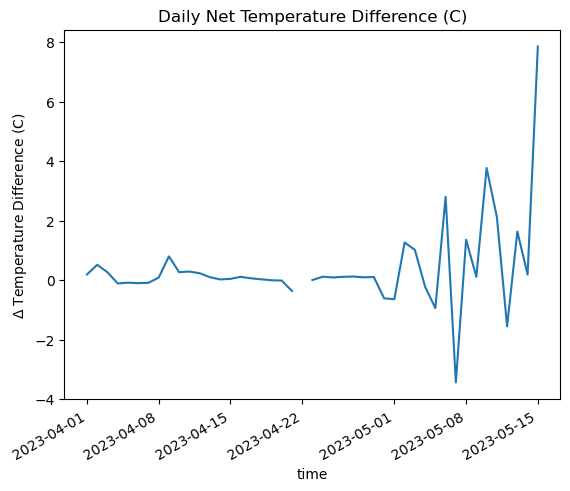

In [126]:
tsnow_daily_diff_0_8m_d.plot()
plt.ylabel('$\Delta$ Temperature Difference (C)')
plt.title('Daily Net Temperature Difference (C)')

### Total Daily Water Vapor Flux
I calculated this by taking the 3m sonic water vapor flux and converting it to a daily depth by taking the hourly mean (in $m/s * g/m^2$) and converting this to $mm/day$ by multiplying by the number of seconds in a day, dividing by the density of water, and converting meters to mm. The total sublimation/melt+evaporation is around 1-inch (20 mm)

Text(0, 0.5, 'Daily Sublimation rate [mm/day]')

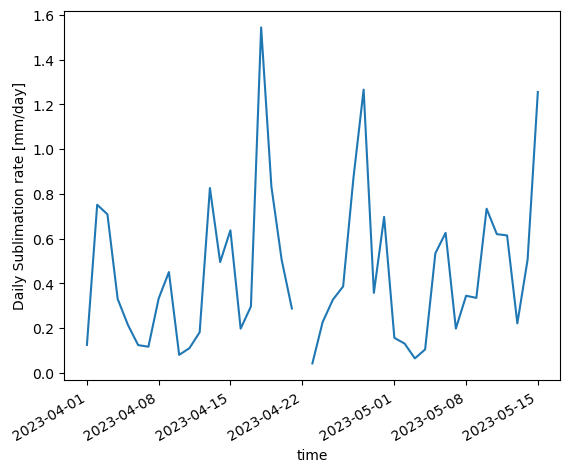

In [131]:
(sos_dataset_60min['w_h2o__3m_c'].resample(time='1D').mean()*24*3600/1e3).plot()
plt.ylabel('Daily Sublimation rate [mm/day]')

In [130]:
(sos_dataset_60min['w_h2o__3m_c'].resample(time='1D').mean()*24*3600/1e3).sum()

<xarray.DataArray 'w_h2o__3m_c' ()>
array(19.775661, dtype=float32)

### Daily Snowmelt

Here I will take the difference between the first and the last measurement for each day to get millimeters of melt per day.

In [98]:
dSWE_1 = sos_dataset_60min['SWE_p1_c'].resample(time='1D').mean().diff(dim='time')
dSWE_2 = sos_dataset_60min['SWE_p2_c'].resample(time='1D').mean().diff(dim='time')
dSWE_3 = sos_dataset_60min['SWE_p3_c'].resample(time='1D').mean().diff(dim='time')
dSWE_4 = sos_dataset_60min['SWE_p4_c'].resample(time='1D').mean().diff(dim='time')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


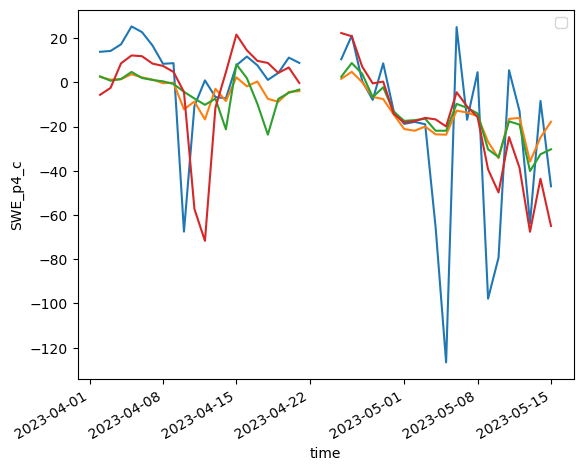

In [99]:
fig, ax = plt.subplots()
dSWE_1.plot(ax=ax)
dSWE_2.plot(ax=ax)
dSWE_3.plot(ax=ax)
dSWE_4.plot(ax=ax)
ax.legend()
ax.set_ylabel('')

Now lets convert this melt into an amount of energy by multiplying our amount of snow that melted and converting it to watts per meter square.

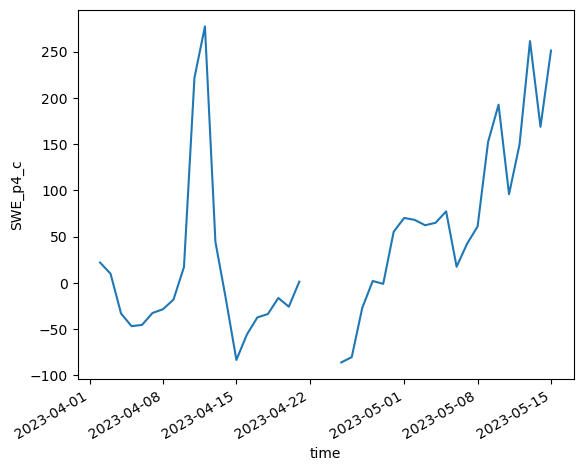

In [102]:
melt_energy_p1 = -dSWE_1 * 334 * 1000 / 3600 /24
melt_energy_p2 = -dSWE_2 * 334 * 1000 / 3600 /24
melt_energy_p3 = -dSWE_3 * 334 * 1000 / 3600 /24
melt_energy_p4 = -dSWE_4 * 334 * 1000 / 3600 /24
melt_energy_p4.plot()

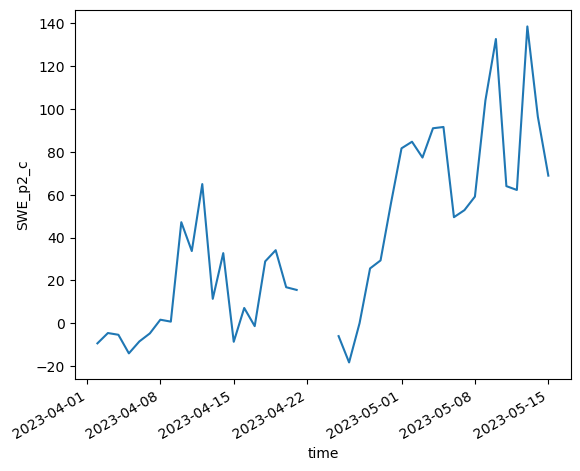

In [106]:
melt_energy_p2.plot()